# X2 - Local Population Dynamics 

Exploration of spatially resolved population dynamics

experiments were run at [45aa5dd](https://github.com/fkuehlein/MayaSim/tree/45aa5dd85e16722cde5317d4735963cae09cbf9f)

also see X2 output folders for post-processed movies


## 01 with trade

(trade income is not very high in this case, therefore might try higher values of $r_{TR}$ for stronger effect.)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import trange, tqdm

n_cells = 101100
t_max = 2000
spinup = 500

In [2]:
output_path = '/media/fritzku/Seagate BUP Slim BL Media/MayaSim output'

### plot aggregate trajectory

(0.0, 2000.0)

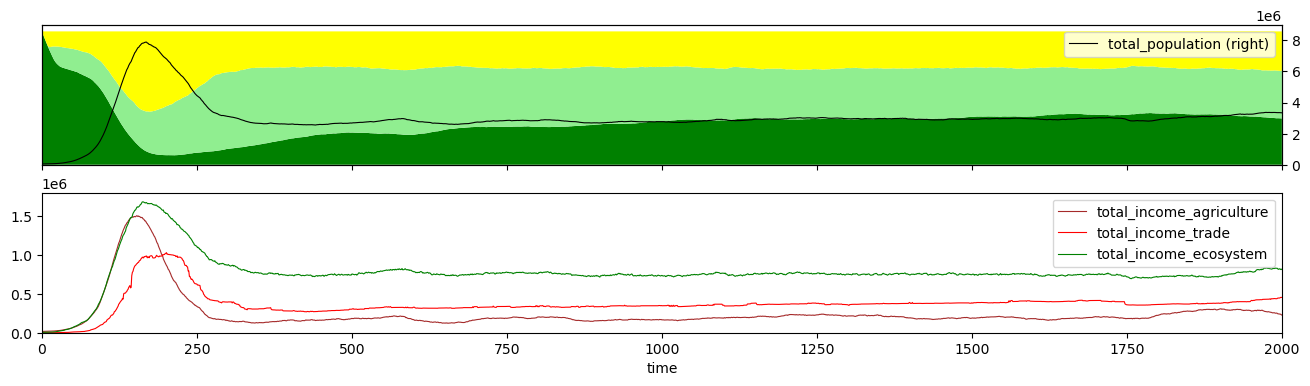

In [7]:
aggregate_run_1 = pd.read_pickle(output_path + '/X2_local_dynamics/raw_data/4000-7000-9500_s0.pkl')['aggregates']

# plot aggregate trajectory
fig, axes = plt.subplots(nrows=2, figsize=(16, 4), sharex=True)

# forest state
axes[0].stackplot(
    aggregate_run_1['time'],
    aggregate_run_1['forest_state_3_cells'], aggregate_run_1['forest_state_2_cells'], aggregate_run_1['forest_state_1_cells'],
    colors=['green', 'lightgreen', 'yellow']
)

# population
aggregate_run_1.plot('time', y='total_population', lw=.8, color='k', ax=axes[0], secondary_y=True, ylim=(0,9e6))

# income
aggregate_run_1.plot('time', y='total_income_agriculture', lw=.8, color='brown', ax=axes[1])
aggregate_run_1.plot('time', y='total_income_trade', lw=.8, color='red', ax=axes[1])
aggregate_run_1.plot('time', y='total_income_ecosystem', lw=.8, color='green', ax=axes[1])
#aggregate_run_1.plot('time', y='killed_settlements', lw=.5, color='blue', ax=axes[1], secondary_y=True)

axes[1].set_ylim(0, 1.8e6)
axes[1].set_xlim(0, t_max)

### collect population trajectories 

collect all settlement's population curves and save to single file (runtime ~ 1.5h)

In [ ]:
data = pd.read_pickle(output_path + f'/X2_local_dynamics/raw_data/4000-7000-9500_s0/settlement_data_001.pkl')
pop = data.transpose().loc[['population']]
pop.index = [1]
pop.columns = data.position

for step in trange(2, t_max+1):
    data = pd.read_pickle(output_path + f'/X2_local_dynamics/raw_data/4000-7000-9500_s0/settlement_data_{step:03d}.pkl')

    pop_step = data.transpose().loc[['population']]
    pop_step.index = [step]
    pop_step.columns = data.position

    pop = pd.concat([pop, pop_step], axis=0)

pop.to_pickle(output_path + '/X2_local_dynamics/results/4000-7000-9500_s0/settlements_pop.pkl')

  0%|          | 0/1999 [00:00<?, ?it/s]

### plot sample trajectories

In [3]:
pop_1 = pd.read_pickle(output_path + '/X2_local_dynamics/results/4000-7000-9500_s0/settlements_pop.pkl')

pop_1.shape

(2000, 17569)

In [107]:
# draw random sample
sample_1 = np.random.randint(0, pop_1.shape[1], size=200)

In [3]:
# calculate necessary population to get first neighboring cells under influence
h = 2.1                 # cell height
w = 2.115740740740741   # cell width
r = np.array([
    w,                                  # 4
    np.sqrt(h**2 + w**2),               # 4
    2*w,                                # 4
    np.sqrt((2*h)**2 + w**2),           # 8
    2*np.sqrt(h**2 + w**2),             # 4
    3*w,                                # 4
    np.sqrt((3*h)**2 + w**2),           # 8
    np.sqrt((3*h)**2 + (2*w)**2),       # 8
    4*w,                                # 4
    np.sqrt((4*h)**2 + w**2),           # 8
    np.sqrt((3*h)**2 + (3*w)**2),       # 4
    np.sqrt((4*h)**2 + (2*w)**2),       # 8
    4*w                                 # 4
])

#r = pop**0.8 / 60
p_min = (r * 60)**(1/0.8)

tranks = [4000, 7000, 9500]

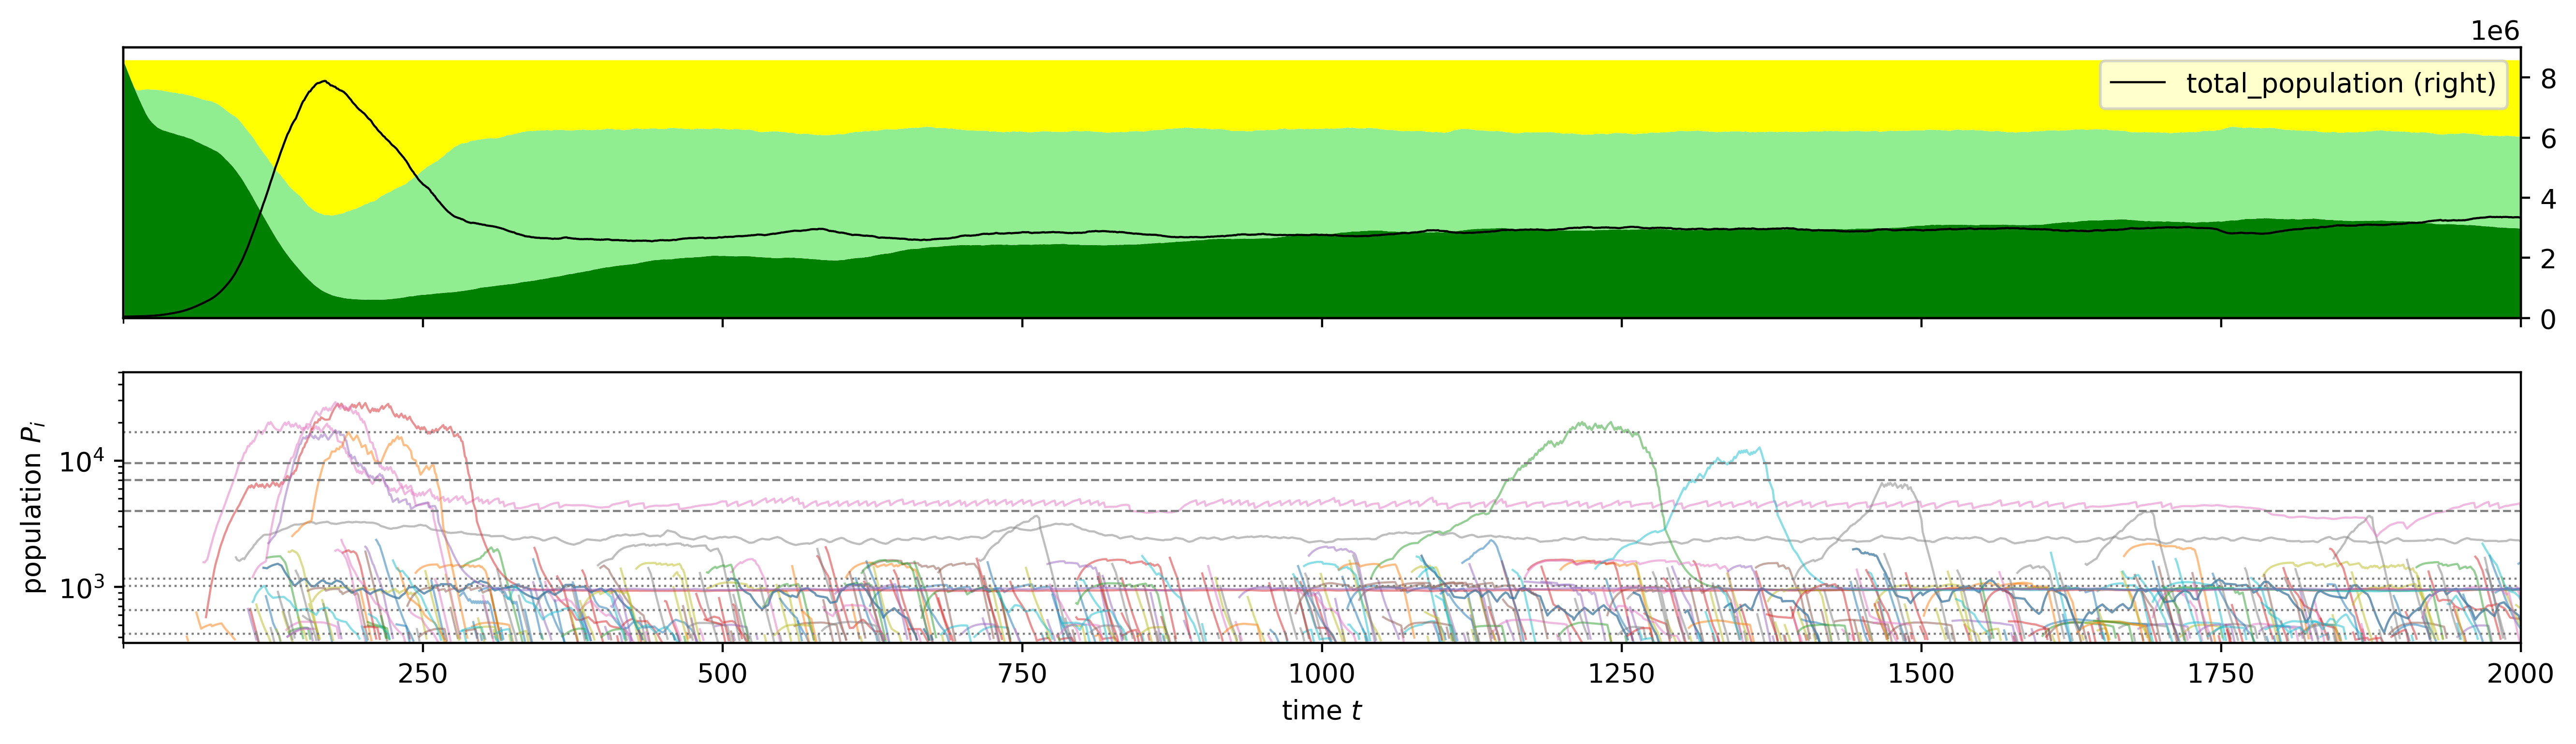

In [ ]:
aggregate_run_1 = pd.read_pickle(output_path + '/X2_local_dynamics/raw_data/4000-7000-9500_s0.pkl')['aggregates']

# plot aggregate trajectory
fig, axes = plt.subplots(nrows=2, figsize=(16, 4), sharex=True, dpi=400)

# forest state
axes[0].stackplot(
    aggregate_run_1['time'],
    aggregate_run_1['forest_state_3_cells'], aggregate_run_1['forest_state_2_cells'], aggregate_run_1['forest_state_1_cells'],
    colors=['green', 'lightgreen', 'yellow']
)

# population
aggregate_run_1.plot('time', y='total_population', lw=.8, color='k', ax=axes[0], secondary_y=True, ylim=(0,9e6))

# plot random sample
pop_1.iloc[:,sample_1].plot(ax=axes[1], lw=.8, alpha=.5, legend=False)
axes[1].set_xticks(pop_1.index.values[249::250])
axes[1].set_yscale('log')
axes[1].set_ylim(360, 5e4)
axes[1].set_xlim(0, t_max)
axes[1].set_ylabel('population $P_i$')
axes[1].set_xlabel('time $t$')

for _, t in enumerate(tranks):
    axes[1].axhline(y=t, c='grey', lw=.8, ls='--')
for _, p in enumerate(p_min[:5]):
    axes[1].axhline(y=p, c='grey', lw=.8, ls=':')
axes[1].axhline(y=360, c='grey', lw=.8 , ls='-')

there seems to be an attractor at pop ~ 1000, why?

- [ ] A migrant settlement spins of when migrant-population share reaches 400 people. If out-migration rate is at max (0.15), this would happen at a total settlement population of 2666 people (or more if out-migration rate is smaller). This doesn't explain it.
- [x] Influence radius reaches [4, 4, 4, 8, 4] next nearest neighbors at [426,  654, 1013, 1156, 1556] inhabitants. Thus, at just over 1000 inhabitants 12 new cells can be gained. If these cells cannot produce enough AG or ES output (e.g. due to cleared forest or degraded soil), the settlement population will always drop below that threshold again.

### simple histogram

In [3]:
# convert to numpy, taking spinup into account
pop_1_arr = pop_1.iloc[spinup:].to_numpy(dtype=float).T
# replace nans with 1.
pop_1_arr = np.nan_to_num(pop_1_arr, nan=1.)
# convert to int
pop_1_arr = pop_1_arr.astype(int)

In [4]:
counts_1, bins_1 = np.histogram(pop_1_arr, bins=np.logspace(np.log10(360), np.log10(4.5e4), 400))

# norm to n_cells * (t_max-spinup)
#counts_1 = counts_1 / (n_cells * (t_max-spinup))

# norm to 1
counts_1 = counts_1/counts_1.sum()

In [141]:
counts_1.sum()

0.9999999999999999

### calculate trapping times

with help of tweaked Pyunicorn: [git+https://github.com/fkuehlein/pyunicorn.git@vertline_dist_2D](https://github.com/fkuehlein/pyunicorn/tree/vertline_dist_2D)

In [6]:
from pyunicorn.timeseries import CrossRecurrencePlot

In [7]:
min = 2
max = 5
thresh = .15

n_bins = 200
#n_bins = np.round((max - min)/(2*thresh)).astype(int) # distinct bins

log_bins = np.linspace(min, max, n_bins)
#log_bins[0] = 0 # use first bin for zero population

In [8]:
v_dist_1 = np.zeros((n_bins, (t_max-spinup)), dtype=np.int64)

for _, pop in enumerate(tqdm(pop_1_arr)):
    crp = CrossRecurrencePlot(log_bins, np.log10(pop), threshold=thresh, silence_level=2)
    v_dist_1 = crp.vertline_dist_2D(v_dist_1)

# add line-length (t_max-spinup) at population 0 for rest of grid cells
# (which never had any settlements on them)
#v_dist_1[0, -1] += (n_cells - pop_1_arr.shape[0])

  0%|          | 0/17569 [00:00<?, ?it/s]

In [8]:
# trapping time
v_min = 2

#  Number of recurrence points that form vertical structures (of at least length v_min)
partial_sum = v_dist_1[:, v_min-1:] @ np.arange(v_min, (t_max-spinup)+1)

#  Total number of vertical lines of at least length v_min
number_vertline = v_dist_1[:, v_min-1:].sum(axis=1)

T_1 = partial_sum / (number_vertline.astype(float) + 1e-8)

### calculate life lengths

In [21]:
thresh = 1
wv_dist_1 = np.zeros((1, (t_max-spinup)), dtype=np.int64)

for _, pop in enumerate(tqdm(pop_1_arr)):
    crp = CrossRecurrencePlot(np.array([1]), pop, threshold=thresh, silence_level=2)
    wv_dist_1 = crp.vertline_dist_2D(wv_dist_1, black=False)

wv_dist_1 = wv_dist_1[0] # compress
wv_dist_1 = wv_dist_1/wv_dist_1.sum() # norm

  0%|          | 0/17569 [00:00<?, ?it/s]

In [22]:
# life length
v_min = 2

#  Number of recurrence points that form vertical structures (of at least length v_min)
partial_sum = wv_dist_1[v_min-1:] @ np.arange(v_min, (t_max-spinup)+1)

#  Total number of vertical lines of at least length v_min
number_vertline = wv_dist_1[v_min-1:].sum()

L_1 = partial_sum / (number_vertline.astype(float) + 1e-8)

## 02 without trade

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import trange, tqdm

n_cells = 101100
t_max = 2000
spinup = 500

### plot aggregate trajectory

(0.0, 2000.0)

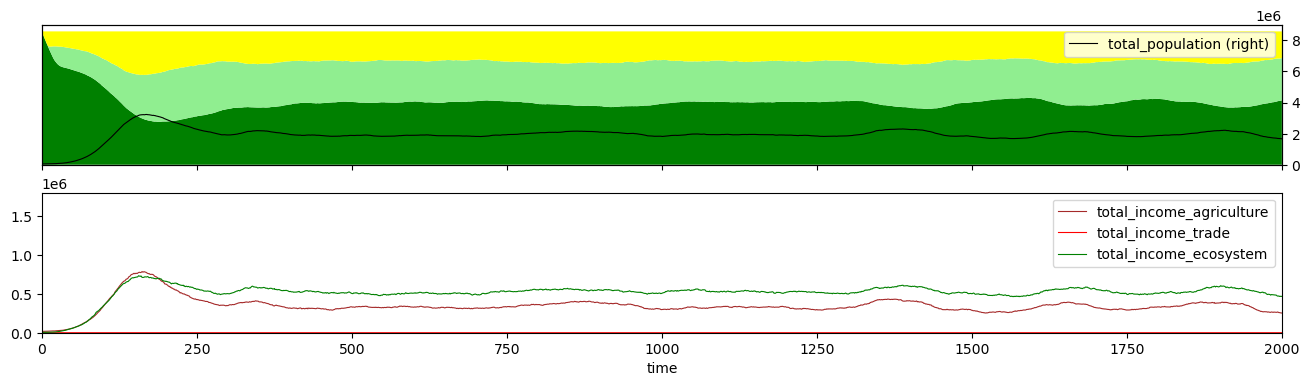

In [8]:
aggregate_run_2 = pd.read_pickle(output_path + '/X2_local_dynamics/raw_data/1000000-1000000-1000000_s0.pkl')['aggregates']

# plot aggregate trajectory
fig, axes = plt.subplots(nrows=2, figsize=(16, 4), sharex=True)

# forest state
axes[0].stackplot(
    aggregate_run_2['time'],
    aggregate_run_2['forest_state_3_cells'], aggregate_run_2['forest_state_2_cells'], aggregate_run_2['forest_state_1_cells'],
    colors=['green', 'lightgreen', 'yellow']
)

# population
aggregate_run_2.plot('time', y='total_population', lw=.8, color='k', ax=axes[0], secondary_y=True, ylim=(0,9e6))

# income
aggregate_run_2.plot('time', y='total_income_agriculture', lw=.8, color='brown', ax=axes[1])
aggregate_run_2.plot('time', y='total_income_trade', lw=.8, color='red', ax=axes[1])
aggregate_run_2.plot('time', y='total_income_ecosystem', lw=.8, color='green', ax=axes[1])
#aggregate_run_2.plot('time', y='killed_settlements', lw=.5, color='blue', ax=axes[1], secondary_y=True)

axes[1].set_ylim(0, 1.8e6)
axes[1].set_xlim(0, t_max)

### collect population trajectories 

collect all settlement's population curves and save to single file (runtime ~ 1.5h)

In [ ]:
aggregate_run_2 = pd.read_pickle(output_path + '/X2_local_dynamics/raw_data/1000000-1000000-1000000_s0/settlement_data_001.pkl')
pop = aggregate_run_2.transpose().loc[['population']]
pop.index = [1]
pop.columns = aggregate_run_2.position

for step in trange(2, t_max+1):
    aggregate_run_2 = pd.read_pickle(output_path + f'/X2_local_dynamics/raw_data/1000000-1000000-1000000_s0/settlement_data_{step:03d}.pkl')

    pop_step = aggregate_run_2.transpose().loc[['population']]
    pop_step.index = [step]
    pop_step.columns = aggregate_run_2.position

    pop = pd.concat([pop, pop_step], axis=0)

pop.to_pickle(output_path + '/X2_local_dynamics/results/1000000-1000000-1000000_s0/settlements_pop.pkl')

  0%|          | 0/1999 [00:00<?, ?it/s]

### plot sample trajectories

In [4]:
pop_2 = pd.read_pickle(output_path + '/X2_local_dynamics/results/1000000-1000000-1000000_s0/settlements_pop.pkl')

pop_2.shape

(2000, 15537)

In [31]:
# draw random sample
sample_2 = np.random.randint(0, pop_2.shape[1], size=200)

Text(0.5, 0, 'time $t$')

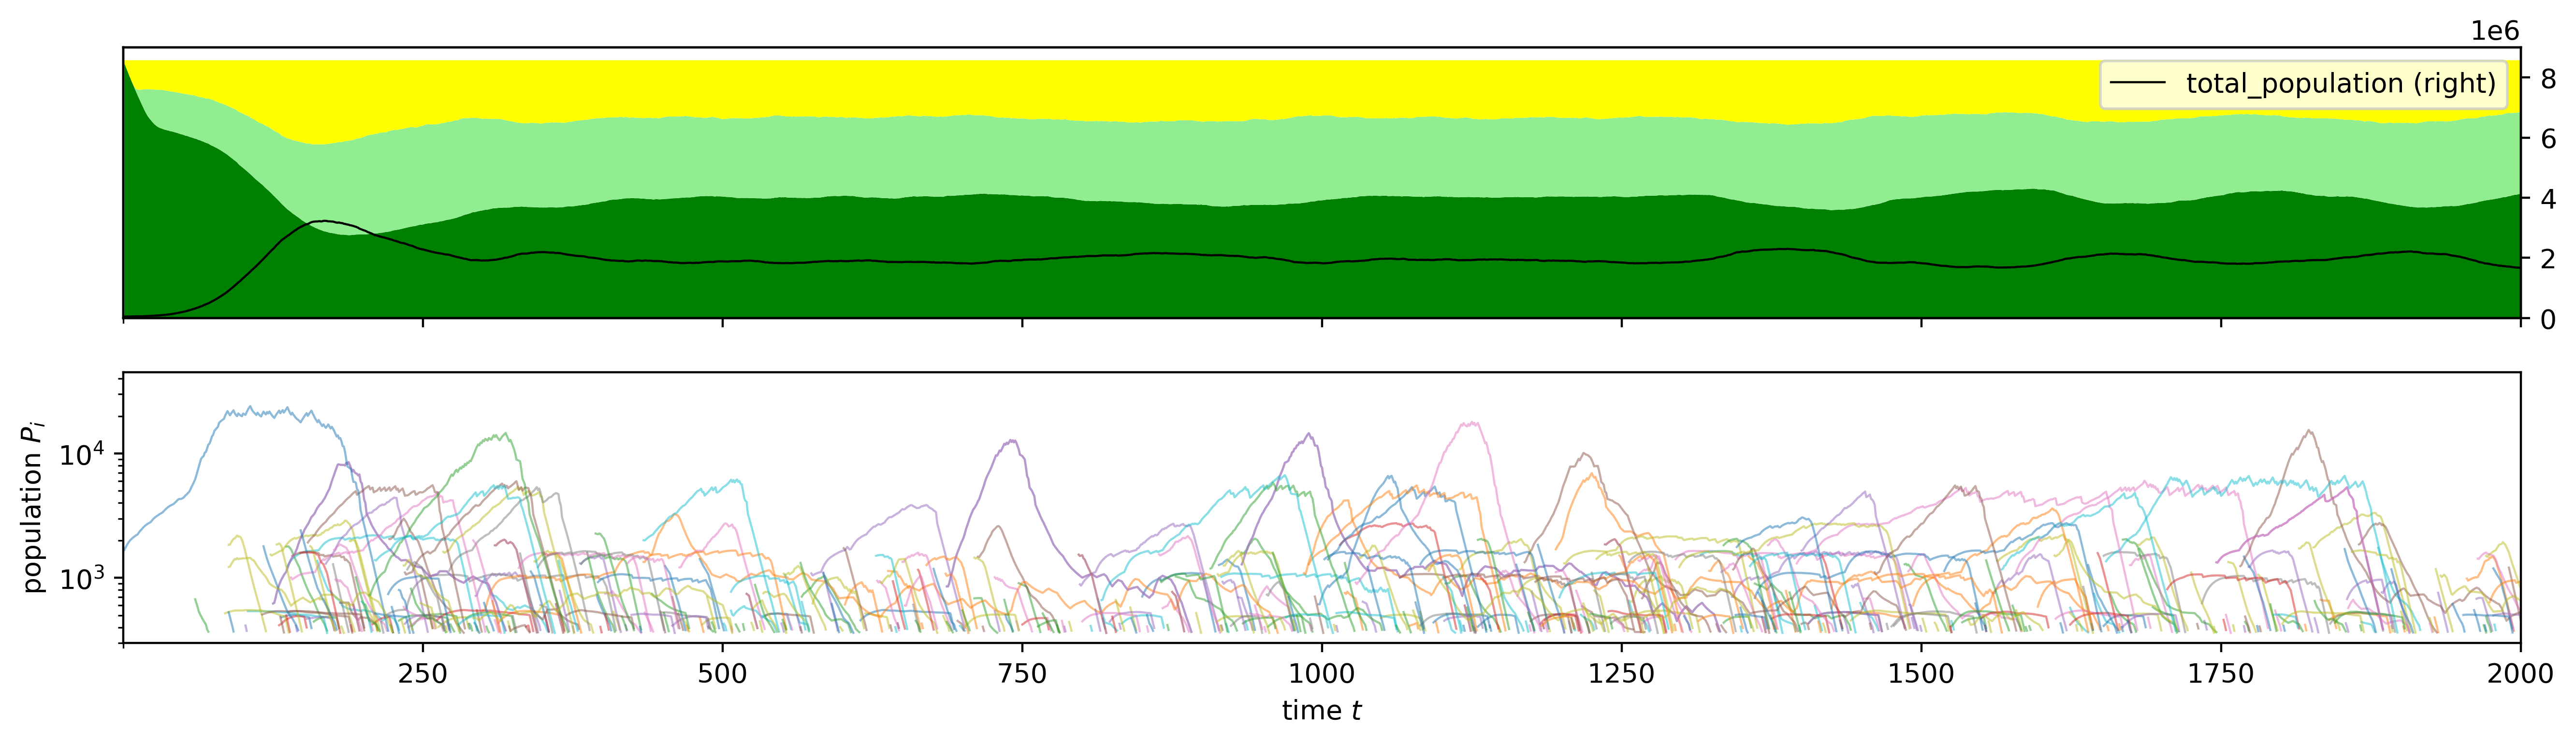

In [ ]:
aggregate_run_2 = pd.read_pickle(output_path + '/X2_local_dynamics/raw_data/1000000-1000000-1000000_s0.pkl')['aggregates']

# plot aggregate trajectory
fig, axes = plt.subplots(nrows=2, figsize=(16, 4), sharex=True, dpi=400)

# forest state
axes[0].stackplot(
    aggregate_run_2['time'],
    aggregate_run_2['forest_state_3_cells'], aggregate_run_2['forest_state_2_cells'], aggregate_run_2['forest_state_1_cells'],
    colors=['green', 'lightgreen', 'yellow']
)

# population
aggregate_run_2.plot('time', y='total_population', lw=.8, color='k', ax=axes[0], secondary_y=True, ylim=(0,9e6))

# draw random sample
pop_2.iloc[:,sample_2].plot(ax=axes[1], lw=.8, alpha=.5, legend=False)
axes[1].set_xticks(pop_2.index.values[249::250])
axes[1].set_yscale('log')
axes[1].set_ylim(300, 4.5e4)
axes[1].set_xlim(0, t_max)
axes[1].set_ylabel('population $P_i$')
axes[1].set_xlabel('time $t$')

# histax = plt.axes((.9, 0.11, 0.1, 0.35))
# histax.stairs(counts_2, bins_2, color='k', orientation='horizontal')
# histax.set_ylim((0, 3e4))
# histax.set_ylim((300, 4.5e4))
# histax.set_yscale('log')
# histax.axis('off')

### simple histogram

In [10]:
# convert to numpy, taking spinup into account
pop_2_arr = pop_2.iloc[spinup:].to_numpy(dtype=float).T
# replace nans with 1.
pop_2_arr = np.nan_to_num(pop_2_arr, nan=1.)
# convert to int
pop_2_arr = pop_2_arr.astype(int)

In [12]:
counts_2, bins_2 = np.histogram(pop_2_arr, bins=np.logspace(np.log10(360), np.log10(4.5e4), 400))

# norm to n_cells * (t_max-spinup)
#counts_2 = counts_2 / (n_cells * (t_max-spinup))

# norm to 1
counts_2 = counts_2/counts_2.sum()

In [143]:
counts_2.sum()

1.0

### calculate trapping times

with help of tweaked Pyunicorn: [git+https://github.com/fkuehlein/pyunicorn.git@vertline_dist_2D](https://github.com/fkuehlein/pyunicorn/tree/vertline_dist_2D)

In [47]:
from pyunicorn.timeseries import CrossRecurrencePlot

In [9]:
min = 2
max = 5
thresh = .15

n_bins = 200
#n_bins = np.round((max - min)/(2*thresh)).astype(int) # distinct bins

log_bins = np.linspace(min, max, n_bins)
#log_bins[0] = 0 # use first bin for zero population

In [11]:
v_dist_2 = np.zeros((n_bins, (t_max-spinup)), dtype=np.int64)

for j, pop in enumerate(tqdm(pop_2_arr)):
    crp = CrossRecurrencePlot(log_bins, np.log10(pop), threshold=thresh, silence_level=2)
    v_dist_2 = crp.vertline_dist_2D(v_dist_2)

# add line-length 1500 at population 0 for rest of grid cells
# (which never had any settlements on them)
#v_dist_2[0, -1] += (n_cells - pop_2_arr.shape[0])

# plt.matshow(v_dist_2)
# plt.gca().invert_yaxis()

  0%|          | 0/15537 [00:00<?, ?it/s]

In [17]:
# trapping time
v_min = 2

#  Number of recurrence points that form vertical structures (of at least length v_min)
partial_sum = v_dist_2[:, v_min-1:] @ np.arange(v_min, (t_max-spinup)+1)

#  Total number of vertical lines of at least length v_min
number_vertline = v_dist_2[:, v_min-1:].sum(axis=1)

T_2 = partial_sum / (number_vertline.astype(float) + 1e-8)

### calculate life lengths

In [23]:
thresh = 1
wv_dist_2 = np.zeros((1, (t_max-spinup)), dtype=np.int64)

for _, pop in enumerate(tqdm(pop_2_arr)):
    crp = CrossRecurrencePlot(np.array([1]), pop, threshold=thresh, silence_level=2)
    wv_dist_2 = crp.vertline_dist_2D(wv_dist_2, black=False)

wv_dist_2 = wv_dist_2[0] # compress
wv_dist_2 = wv_dist_2/wv_dist_2.sum() # norm

  0%|          | 0/15537 [00:00<?, ?it/s]

In [24]:
# life length
v_min = 2

#  Number of recurrence points that form vertical structures (of at least length v_min)
partial_sum = wv_dist_2[v_min-1:] @ np.arange(v_min, (t_max-spinup)+1)

#  Total number of vertical lines of at least length v_min
number_vertline = wv_dist_2[v_min-1:].sum()

L_2 = partial_sum / (number_vertline.astype(float) + 1e-8)

L_2

42.548478207416444

## create plots

In [10]:
from matplotlib.ticker import FuncFormatter, FormatStrFormatter

In [ ]:
# draw random sample
sample_1 = np.random.randint(0, pop_1.shape[1], size=2000)

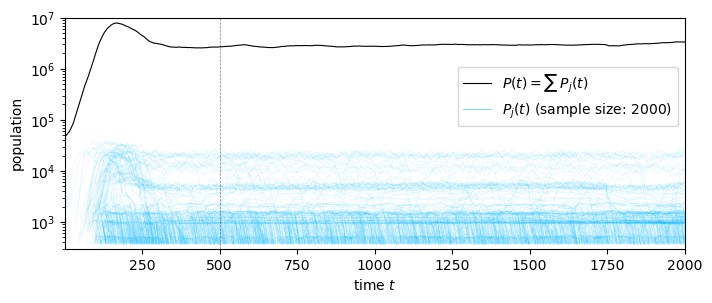

In [ ]:
fig, ax = plt.subplots(figsize=(8,3))

aggregate_run_1.plot('time', y='total_population', ls='-', lw=.8, c='k', ax=ax)

#pop_1.iloc[:,:200].plot(c='C0', alpha=.1, lw=.4, ax=ax) # plot first 200
pop_1.iloc[:,sample_1].plot(c='deepskyblue', alpha=.1, lw=.4, legend=False, ax=ax) # plot random sample

ax.set_xticks(pop_1.index.values[249::250])
ax.set_xlabel('time $t$')
ax.set_xlim((0, 2000))
ax.set_ylabel('population')
ax.set_ylim((300, 1e7))
ax.set_yscale('log')

# mark spinup range
ax.axvline(spinup, ls='--', c='k', lw=.5, alpha=.5)

leg = ax.legend(['$P(t) = \sum \: P_j(t)$', '$P_j(t)$ (sample size: 2000)'], loc='lower right', bbox_to_anchor=(1, .5))
leg.get_lines()[1].set_alpha(1)

small plot

In [5]:
# draw random sample
sample_1_small = np.random.randint(0, pop_1.shape[1], size=500)

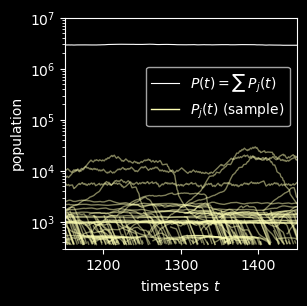

In [27]:
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(3,3))

aggregate_run_1.plot('time', y='total_population', ls='-', lw=.8, c='w', ax=ax)

#pop_1.iloc[:,:200].plot(c='C0', alpha=.5, lw=1, legend=False, ax=ax) # plot first 200
pop_1.iloc[:,sample_1_small].plot(c='C1', alpha=.5, lw=1, legend=False, ax=ax) # plot random sample

ax.set_xticks(pop_1.index.values[99::100])
ax.set_xlabel('timesteps $t$')
ax.set_xlim((1150, 1450))
ax.set_ylabel('population')
ax.set_ylim((300, 1e7))
ax.set_yscale('log')

# mark spinup range
ax.axvline(spinup, ls='--', c='k', lw=.5, alpha=.5)

leg = ax.legend(['$P(t) = \sum \: P_j(t)$', '$P_j(t)$ (sample)'], loc='lower right', bbox_to_anchor=(1, .5))
leg.get_lines()[1].set_alpha(1)

plt.savefig("/home/fritzku/Desktop/PIK/MayaSim/egu_25/X2_zoomed.svg")

In [ ]:
# draw random sample
sample_2 = np.random.randint(0, pop_2.shape[1], size=2000)

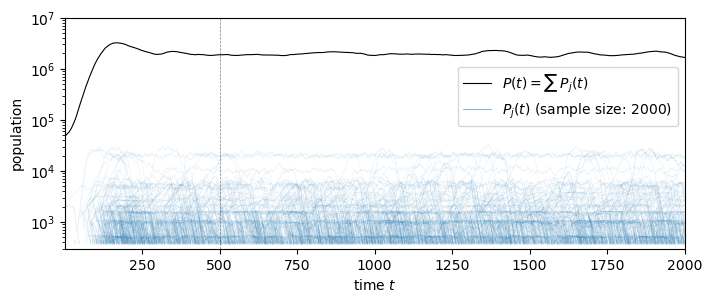

In [ ]:
fig, ax = plt.subplots(figsize=(8,3))

aggregate_run_2.plot('time', y='total_population', ls='-', lw=.8, c='k', ax=ax)

#pop_2.iloc[:,:200].plot(c='C0', alpha=.1, lw=.4, ax=ax) # plot first 200
pop_2.iloc[:,sample_2].plot(c='C0', alpha=.1, lw=.4, legend=False, ax=ax) # plot random sample

ax.set_xticks(pop_2.index.values[249::250])
ax.set_xlabel('time $t$')
ax.set_xlim((0, 2000))
ax.set_ylabel('population')
ax.set_ylim((300, 1e7))
ax.set_yscale('log')

# mark spinup range
ax.axvline(spinup, ls='--', c='k', lw=.5, alpha=.5)

leg = ax.legend(['$P(t) = \sum \: P_j(t)$', '$P_j(t)$ (sample size: 2000)'], loc='lower right', bbox_to_anchor=(1, .5))
leg.get_lines()[1].set_alpha(1)

small plot

In [15]:
# draw random sample
sample_2_small = np.random.randint(0, pop_2.shape[1], size=500)

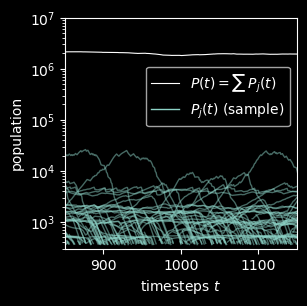

In [16]:
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(3,3))

aggregate_run_2.plot('time', y='total_population', ls='-', lw=.8, c='w', ax=ax)

#pop_2.iloc[:,:200].plot(c='C0', alpha=.5, lw=1, legend=False, ax=ax) # plot first 200
pop_2.iloc[:,sample_2_small].plot(c='C0', alpha=.5, lw=1, legend=False, ax=ax) # plot random sample

ax.set_xticks(pop_2.index.values[99::100])
ax.set_xlabel('timesteps $t$')
ax.set_xlim((850, 1150))
ax.set_ylabel('population')
ax.set_ylim((300, 1e7))
ax.set_yscale('log')

# mark spinup range
ax.axvline(spinup, ls='--', c='k', lw=.5, alpha=.5)

leg = ax.legend(['$P(t) = \sum \: P_j(t)$', '$P_j(t)$ (sample)'], loc='lower right', bbox_to_anchor=(1, .5))
leg.get_lines()[1].set_alpha(1)

plt.savefig("/home/fritzku/Desktop/PIK/MayaSim/egu_25/X2_notrade_zoomed.svg")


In [5]:
# calculate necessary population to get first neighboring cells under influence
h = 2.1                 # cell height
w = 2.115740740740741   # cell width
r = np.array([
    w,                                  # 4
    np.sqrt(h**2 + w**2),               # 4
    2*w,                                # 4
    np.sqrt((2*h)**2 + w**2),           # 8
    2*np.sqrt(h**2 + w**2),             # 4
    3*w,                                # 4
    np.sqrt((3*h)**2 + w**2),           # 8
    np.sqrt((3*h)**2 + (2*w)**2),       # 8
    4*w,                                # 4
    np.sqrt((4*h)**2 + w**2),           # 8
    np.sqrt((3*h)**2 + (3*w)**2),       # 4
    np.sqrt((4*h)**2 + (2*w)**2),       # 8
    4*w                                 # 4
])

#r = pop**0.8 / 60
p_min = (r * 60)**(1/0.8)

tranks = [4000, 7000, 9500]

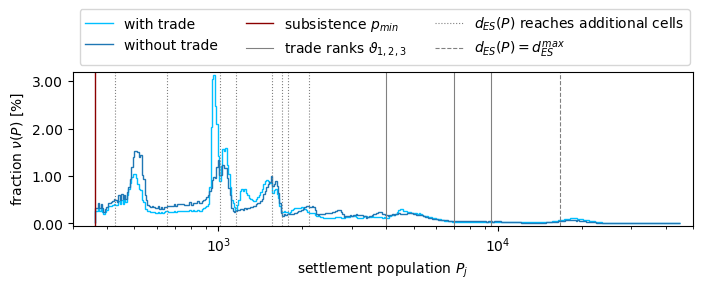

In [39]:
# simple histogram

fig, ax = plt.subplots(figsize=(8, 2))

ax.stairs(counts_1*100, bins_1, color='deepskyblue', label='with trade')
ax.stairs(counts_2*100, bins_2, color='C0', label='without trade')
ax.set_xlim((300, 5e4))
ax.set_xscale('log')
ax.set_ylim((-.05, 3.2))
#ax.set_ylim((1e-2, 5))
#ax.set_ylim((1e-4, .1))
#ax.set_yscale('log')
#ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:g}'.format(y)))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_xlabel('settlement population $P_j$')
ax.set_ylabel('fraction $\\nu(P)$ [%]')

ax.axvline(x=360, c='#8b0000', lw=1 , ls='-', label='subsistence $p_{min}$')

for i, t in enumerate(tranks):
    line = ax.axvline(x=t, c='grey', lw=.8, ls='-')
    if i == 0:
        line.set_label('trade ranks $\\vartheta_{1,2,3}$')

for i, p in enumerate(p_min[:-5]):
    line = ax.axvline(x=p, c='grey', lw=.8, ls=':')
    if i == 0:
        line.set_label('$d_{ES}(P)$ reaches additional cells')

ax.axvline(x=(40 * 60)**(1/0.8), c='grey', lw=.8 , ls='--', label='$d_{ES}(P) = d_{ES}^{max}$')

ax.legend(ncols=3, loc='lower left', bbox_to_anchor=(0,1))

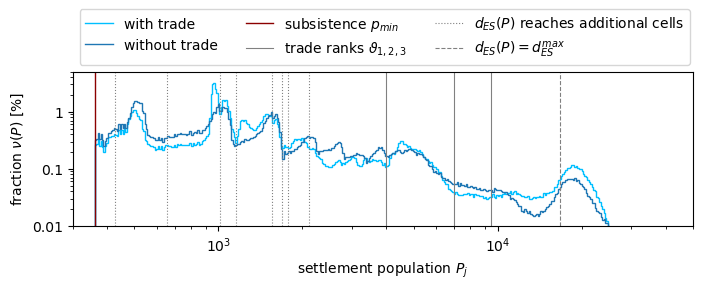

In [38]:
# simple histogram

fig, ax = plt.subplots(figsize=(8, 2))

ax.stairs(counts_1*100, bins_1, color='deepskyblue', label='with trade')
ax.stairs(counts_2*100, bins_2, color='C0', label='without trade')
ax.set_xlim((300, 5e4))
ax.set_xscale('log')
#ax.set_ylim((-.05, 3.2))
ax.set_ylim((1e-2, 5))
#ax.set_ylim((1e-4, .1))
ax.set_yscale('log')
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:g}'.format(y)))
ax.set_xlabel('settlement population $P_j$')
ax.set_ylabel('fraction $\\nu(P)$ [%]')

ax.axvline(x=360, c='#8b0000', lw=1 , ls='-', label='subsistence $p_{min}$')

for i, t in enumerate(tranks):
    line = ax.axvline(x=t, c='grey', lw=.8, ls='-')
    if i == 0:
        line.set_label('trade ranks $\\vartheta_{1,2,3}$')

for i, p in enumerate(p_min[:-5]):
    line = ax.axvline(x=p, c='grey', lw=.8, ls=':')
    if i == 0:
        line.set_label('$d_{ES}(P)$ reaches additional cells')

ax.axvline(x=(40 * 60)**(1/0.8), c='grey', lw=.8 , ls='--', label='$d_{ES}(P) = d_{ES}^{max}$')

ax.legend(ncols=3, loc='lower left', bbox_to_anchor=(0,1))

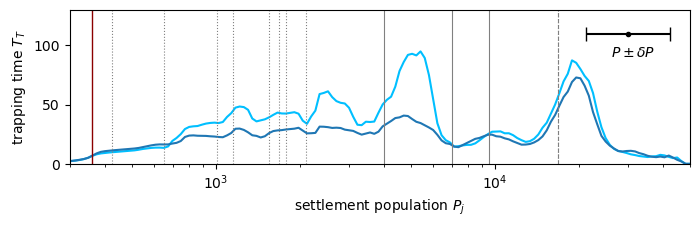

In [120]:
# trapping times

fig, ax = plt.subplots(figsize=(8, 2))

p1, = ax.plot(10**log_bins, T_1, color='deepskyblue', label='with trade')
p2, = ax.plot(10**log_bins, T_2, color='C0', label='without trade')
ax.set_xlim((300, 5e4))
ax.set_xscale('log')
ax.set_ylim((0, 130))
ax.set_xlabel('settlement population $P_j$')
ax.set_ylabel('trapping time $T_T$')

ax.errorbar(3e4, 110, xerr=[[3e4-3*10**(4-thresh)], [3*10**(4+thresh)-3e4]], c='k', fmt='.', capsize=5)
ax.text(2.6e4, 90, '$P \pm \delta P$')

ax.axvline(x=360, c='#8b0000', lw=1 , ls='-')

for i, p in enumerate(p_min[:-5]):
    ax.axvline(x=p, c='grey', lw=.8, ls=':')

for i, t in enumerate(tranks):
    ax.axvline(x=t, c='grey', lw=.8, ls='-')

ax.axvline(x=(40 * 60)**(1/0.8), c='grey', lw=.8 , ls='--')

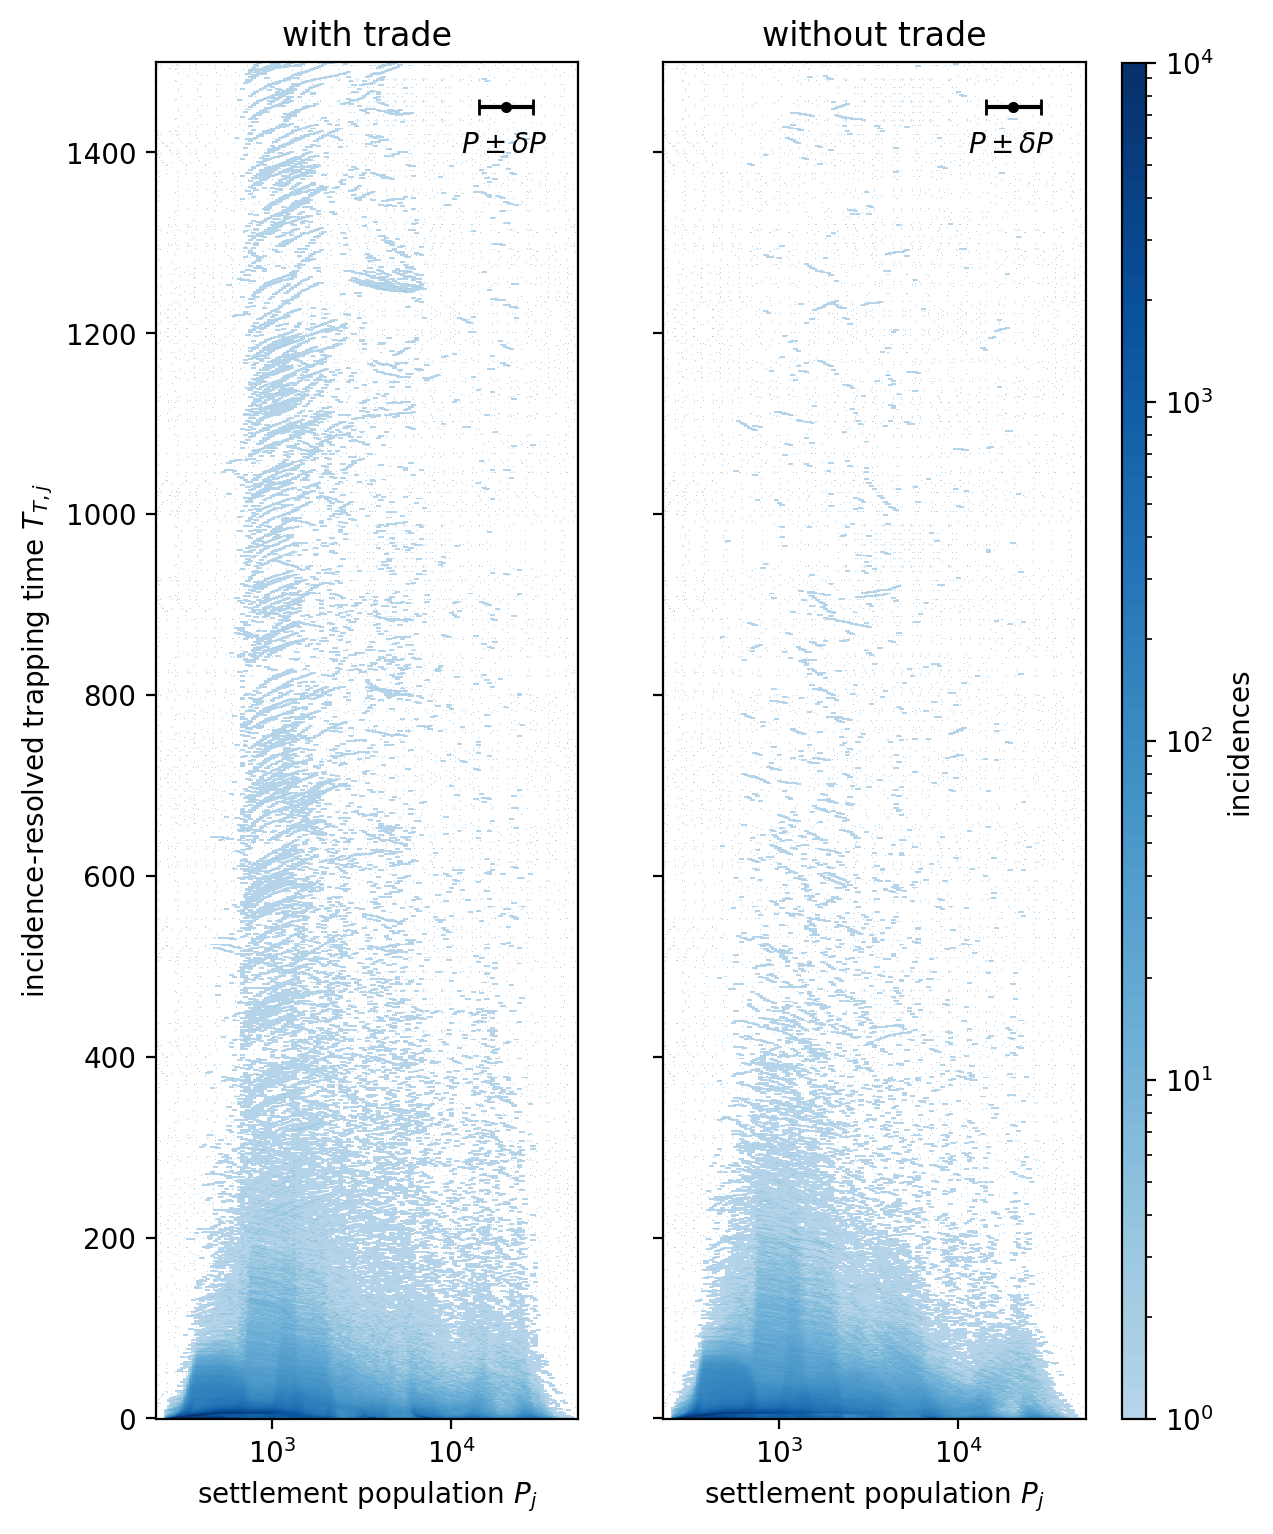

In [64]:
import matplotlib as mpl

fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(6,10), dpi=200)

# tweak ticks to log scale
ticks = np.where(log_bins - log_bins.astype(int) <= 1.5e-2)[0]
labels = ['10$^2$', '10$^3$', '10$^4$', '10$^5$']

# project log scale to bins to place correctly sized errorbar
def log_to_bin(logP):
    return (logP-min)/(max-min)*n_bins

for i, (ax, dist) in enumerate([[axes[0], v_dist_1], [axes[1], v_dist_2]]):
    # start colormap at 0.3 of original color range to distinguish incidence 1 from 0
    cmap = mpl.colors.ListedColormap(mpl.cm.Blues(np.linspace(0.3, 1, 128)))
    
    im = ax.imshow(dist.T, cmap=cmap, norm=mpl.colors.LogNorm(vmin=1, vmax=1e4))
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels)
    ax.invert_yaxis()
    ax.set_aspect(1/3)
    ax.set_xlabel('settlement population $P_j$')
    ax.set_xlim((log_to_bin(np.log10(230)), log_to_bin(np.log10(5e4))))

    ax.errorbar(log_to_bin(4.3), 1450, xerr=log_to_bin(min+thresh), c='k', fmt='.', capsize=3)
    ax.text(log_to_bin(4.05), 1400, '$P \pm \delta P$')

axes[0].set_ylabel('incidence-resolved trapping time $T_{T,j}$')
axes[0].set_title('with trade')
axes[1].set_title('without trade')

# add colorbar
cax = plt.axes((.93, 0.156, 0.02, 0.678))
cbar = fig.colorbar(im, cax=cax, label='incidences')

In [26]:
# smoothen life length:
s = 15
range = np.arange(int(len(wv_dist_1)/s)+1)

ll_1_smooth = np.array([wv_dist_1[(i*s):(i+1)*s].sum() for i in range[:-1]])
ll_2_smooth = np.array([wv_dist_2[(i*s):(i+1)*s].sum() for i in range[:-1]])

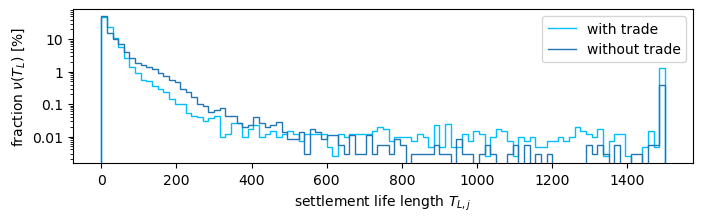

In [40]:
fig, ax = plt.subplots(figsize=(8,2))

p1 = ax.stairs(ll_1_smooth*100, range*s, color='deepskyblue', label='with trade')
p2 = ax.stairs(ll_2_smooth*100, range*s, color='C0', label='without trade')
#ax.set_ylim(.5, 1e5)
#ax.set_xlim(-10,1510)
ax.set_yscale('log')
ax.set_xlabel('settlement life length $T_{L,j}$')
ax.set_ylabel('fraction $\\nu(T_{L})$ [%]')
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:g}'.format(y)))

ax.legend(loc='upper right')

## Compare trapping times

- with lower thresholds, trade peaks as well as peak at 2e4 begin to disappear, instead lower peaks become more prominent --> lower peaks are more distinct, higher peaks have higher variance. also lower populations have a much higher frequency, which the does not fall into account with the trapping time.

- high peaks might appear due to turnaround? not only, long trapping times at high levels are apparent from sample trajectories.

### thresh = 0.2

In [ ]:
min = 2
max = 5
thresh = .2

n_bins = 150
#n_bins = np.round((max - min)/(2*thresh)).astype(int) # distinct bins

log_bins = np.linspace(min, max, n_bins)
log_bins[0] = 0 # use first bin for zero population

TT_0 =  1084
L_hat =  416


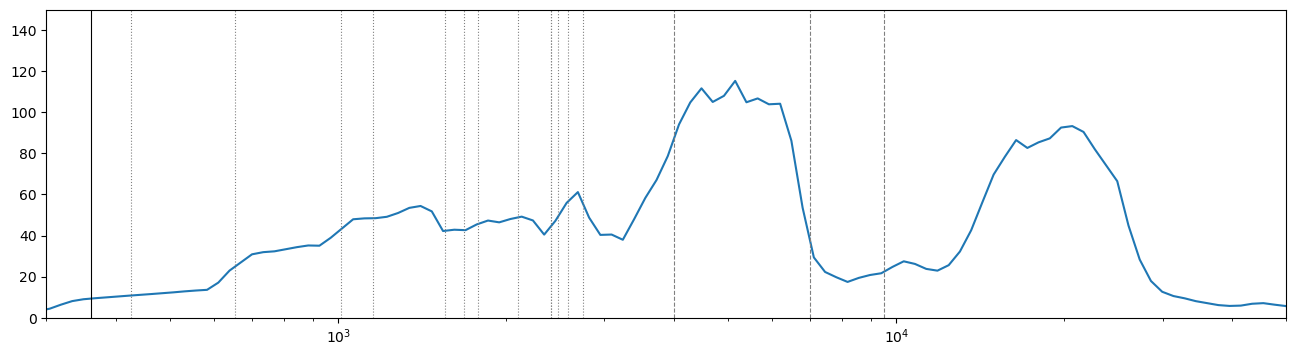

In [ ]:
print('TT_0 = ', round(T_1[0]))
print('L_hat = ', round((t_max-spinup) - T_1[0]))

fig, ax = plt.subplots(figsize=(16,4))

ax.plot(10**log_bins, T_1)
ax.set_xlim((300, 5e4))
ax.set_xscale('log')
ax.set_ylim((0, 150))

for _, t in enumerate(tranks):
    ax.axvline(x=t, c='grey', lw=.8, ls='--')

for _, p in enumerate(p_min):
    ax.axvline(x=p, c='grey', lw=.8, ls=':')

ax.axvline(x=360, c='black', lw=.8 , ls='-', label='subsistence threshold')

TT_0 =  1119
L_hat =  381


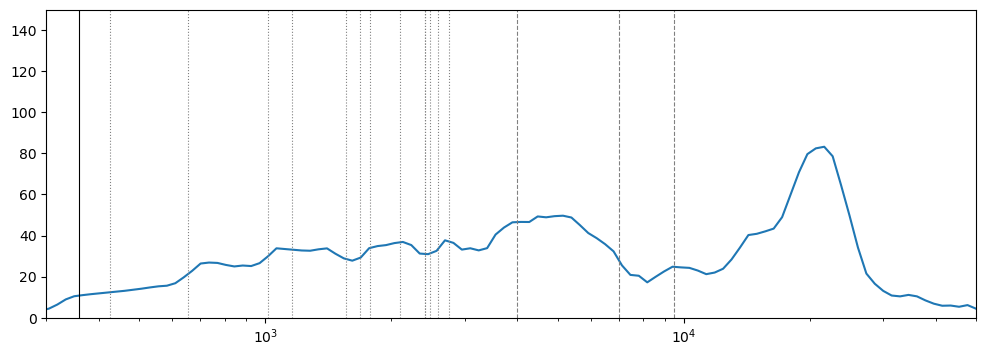

In [ ]:
print('TT_0 = ', round(T_2[0]))
print('L_hat = ', round((t_max-spinup) - T_2[0]))

fig, ax = plt.subplots(figsize=(12,4))

ax.plot(10**log_bins, T_2)
ax.set_xlim((300, 5e4))
ax.set_xscale('log')
ax.set_ylim((0, 150))

for _, t in enumerate(tranks):
    ax.axvline(x=t, c='grey', lw=.8, ls='--')

for _, p in enumerate(p_min):
    ax.axvline(x=p, c='grey', lw=.8, ls=':')

ax.axvline(x=360, c='black', lw=.8 , ls='-', label='subsistence threshold')

### thresh = 0.15

In [ ]:
min = 2
max = 5
thresh = .15

n_bins = 200
#n_bins = np.round((max - min)/(2*thresh)).astype(int) # distinct bins

log_bins = np.linspace(min, max, n_bins)
log_bins[0] = 0 # use first bin for zero population

TT_0 =  1084
L_hat =  416


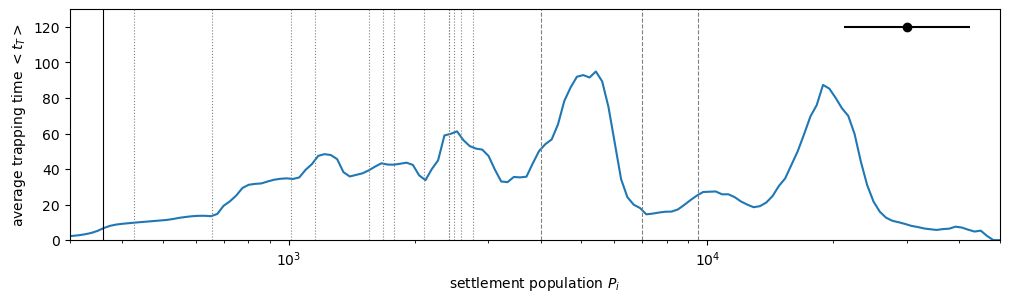

In [124]:
print('TT_0 = ', round(T_1[0]))
print('L_hat = ', round((t_max-spinup) - T_1[0]))

fig, ax = plt.subplots(figsize=(12,3))

ax.plot(10**log_bins, T_1)
ax.set_xlim((300, 5e4))
ax.set_xscale('log')
ax.set_ylim((0, 130))
ax.set_xlabel('settlement population $P_i$')
ax.set_ylabel('average trapping time $<t_T>$')

ax.errorbar(x=3e4, y=120, xerr=[[3e4-3*10**(4-thresh)], [3*10**(4+thresh)-3e4]], c='k', fmt='o')

for _, t in enumerate(tranks):
    ax.axvline(x=t, c='grey', lw=.8, ls='--')

for _, p in enumerate(p_min):
    ax.axvline(x=p, c='grey', lw=.8, ls=':')

ax.axvline(x=360, c='black', lw=.8 , ls='-', label='subsistence threshold')

TT_0 =  1119
L_hat =  381


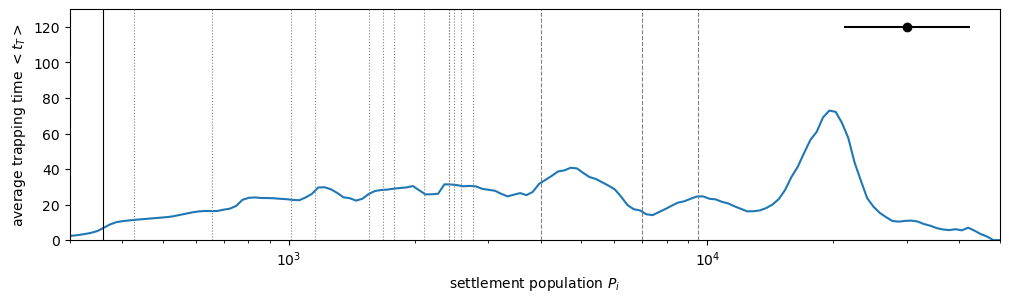

In [125]:
print('TT_0 = ', round(T_2[0]))
print('L_hat = ', round((t_max-spinup) - T_2[0]))

fig, ax = plt.subplots(figsize=(12,3))

ax.plot(10**log_bins, T_2)
ax.set_xlim((300, 5e4))
ax.set_xscale('log')
ax.set_ylim((0, 130))
ax.set_xlabel('settlement population $P_i$')
ax.set_ylabel('average trapping time $<t_T>$')

ax.errorbar(x=3e4, y=120, xerr=[[3e4-3*10**(4-thresh)], [3*10**(4+thresh)-3e4]], c='k', fmt='o')

for _, t in enumerate(tranks):
    ax.axvline(x=t, c='grey', lw=.8, ls='--')

for _, p in enumerate(p_min):
    ax.axvline(x=p, c='grey', lw=.8, ls=':')

ax.axvline(x=360, c='black', lw=.8 , ls='-', label='subsistence threshold')

### thresh = 0.1

In [ ]:
min = 2
max = 5
thresh = .1

n_bins = 150
#n_bins = np.round((max - min)/(2*thresh)).astype(int) # distinct bins

log_bins = np.linspace(min, max, n_bins)
log_bins[0] = 0 # use first bin for zero population

TT_0 =  1084
L_hat =  416


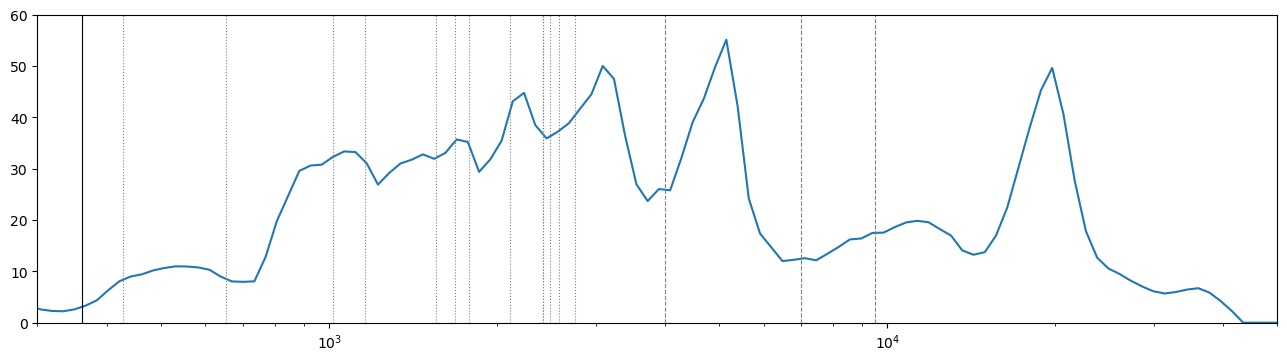

In [ ]:
print('TT_0 = ', round(T_1[0]))
print('L_hat = ', round((t_max-spinup) - T_1[0]))

fig, ax = plt.subplots(figsize=(16,4))

ax.plot(10**log_bins, T_1)
ax.set_xlim((300, 5e4))
ax.set_xscale('log')
ax.set_ylim((0, 60))

for _, t in enumerate(tranks):
    ax.axvline(x=t, c='grey', lw=.8, ls='--')

for _, p in enumerate(p_min):
    ax.axvline(x=p, c='grey', lw=.8, ls=':')

ax.axvline(x=360, c='black', lw=.8 , ls='-', label='subsistence threshold')

TT_0 =  1119
L_hat =  381


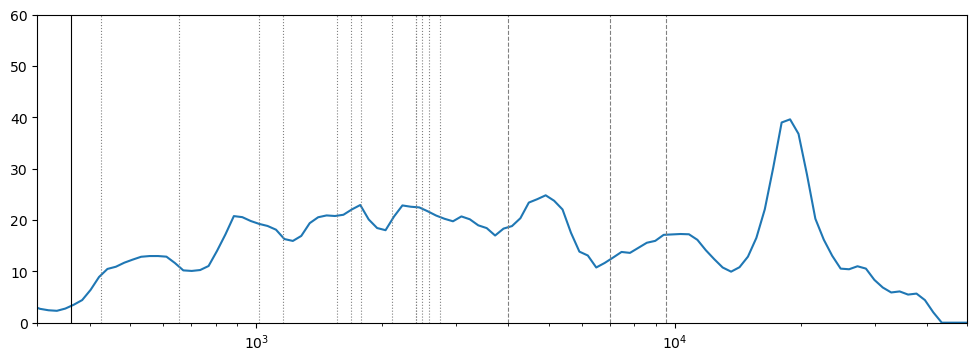

In [164]:
print('TT_0 = ', round(T_2[0]))
print('L_hat = ', round((t_max-spinup) - T_2[0]))

fig, ax = plt.subplots(figsize=(12,4))

ax.plot(10**log_bins, T_2)
ax.set_xlim((300, 5e4))
ax.set_xscale('log')
ax.set_ylim((0, 60))

for _, t in enumerate(tranks):
    ax.axvline(x=t, c='grey', lw=.8, ls='--')

for _, p in enumerate(p_min):
    ax.axvline(x=p, c='grey', lw=.8, ls=':')

ax.axvline(x=360, c='black', lw=.8 , ls='-', label='subsistence threshold')

### thresh = 0.01, distinct

In [ ]:
min = 2
max = 5
thresh = .01

#n_bins = 150
n_bins = np.round((max - min)/(2*thresh)).astype(int) # distinct bins

log_bins = np.linspace(min, max, n_bins)
log_bins[0] = 0 # use first bin for zero population

TT_0 =  1084
L_hat =  416


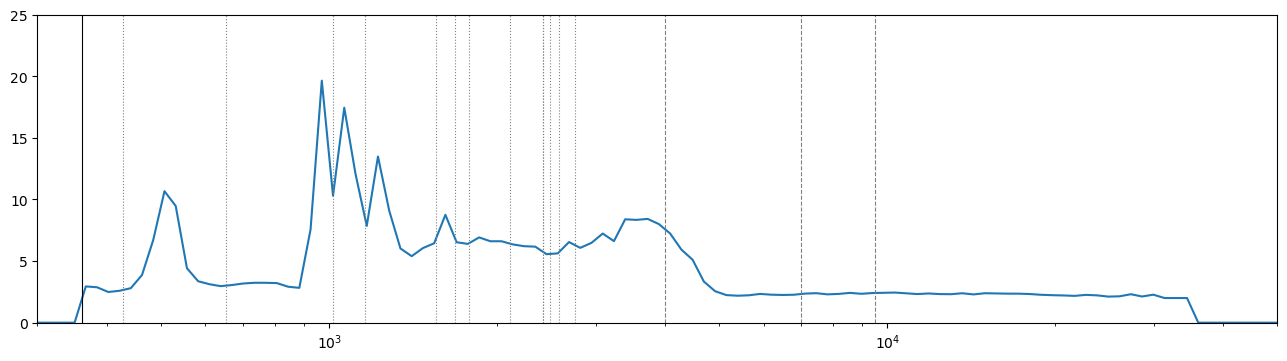

In [ ]:
print('TT_0 = ', round(T_1[0]))
print('L_hat = ', round((t_max-spinup) - T_1[0]))

fig, ax = plt.subplots(figsize=(16,4))

ax.plot(10**log_bins, T_1)
ax.set_xlim((300, 5e4))
ax.set_xscale('log')
ax.set_ylim((0, 25))

for _, t in enumerate(tranks):
    ax.axvline(x=t, c='grey', lw=.8, ls='--')

for _, p in enumerate(p_min):
    ax.axvline(x=p, c='grey', lw=.8, ls=':')

ax.axvline(x=360, c='black', lw=.8 , ls='-', label='subsistence threshold')

TT_0 =  1119
L_hat =  381


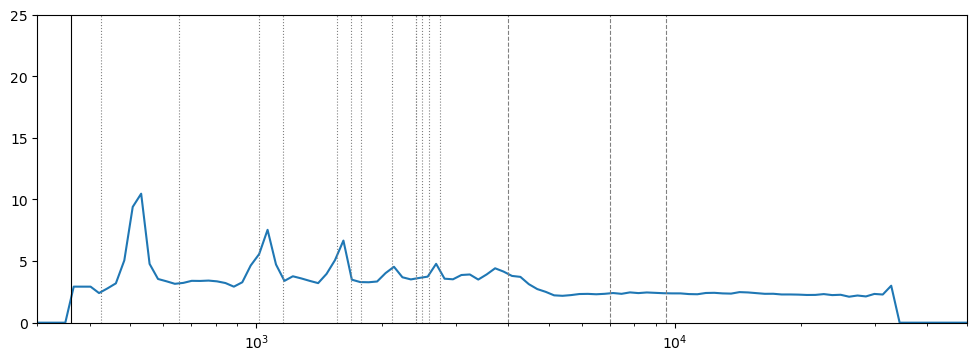

In [ ]:
print('TT_0 = ', round(T_2[0]))
print('L_hat = ', round((t_max-spinup) - T_2[0]))

fig, ax = plt.subplots(figsize=(12,4))

ax.plot(10**log_bins, T_2)
ax.set_xlim((300, 5e4))
ax.set_xscale('log')
ax.set_ylim((0, 25))

for _, t in enumerate(tranks):
    ax.axvline(x=t, c='grey', lw=.8, ls='--')

for _, p in enumerate(p_min):
    ax.axvline(x=p, c='grey', lw=.8, ls=':')

ax.axvline(x=360, c='black', lw=.8 , ls='-', label='subsistence threshold')

## check ecosystem income

in the movie it looks like influence radius (or influenced cells) suddenly drop to zero, and *then* population starts to shrink. It should be the other way around!

therefore look at:
- population (looks alright, no single-time-step drops, see below)
- influence radius/influenced cells (not logged, would have to re-run)
- ecosystem service income: compare patterns, see below:

In [ ]:
steps = 2000

data = pd.read_pickle(output_path + '/X2_local_dynamics/raw_data/1000000-1000000-1000000_s0/settlement_data_001.pkl')
es = data.transpose().loc[['es income']]
es.index = ['1']
es.columns = data.position

for step in trange(2, steps+1):
    data = pd.read_pickle(output_path + f'/X2_local_dynamics/raw_data/1000000-1000000-1000000_s0/settlement_data_{step:03d}.pkl')

    es_step = data.transpose().loc[['es income']]
    es_step.index = [str(step)]
    es_step.columns = data.position

    es = pd.concat([es, es_step], axis=0)

es.to_pickle(output_path + '/X2_local_dynamics/results/1000000-1000000-1000000_s0/settlements_es.pkl')

  0%|          | 0/1999 [00:00<?, ?it/s]

In [ ]:
pop_2 = pd.read_pickle(output_path + '/X2_local_dynamics/results/1000000-1000000-1000000_s0/settlements_pop.pkl')

es_2 = pd.read_pickle(output_path + '/X2_local_dynamics/results/1000000-1000000-1000000_s0/settlements_es.pkl')

(2000, 15537)

In [7]:
# draw random sample
sample_es = np.random.randint(0, es_2.shape[1], size=200)

Text(0.5, 0, 'timesteps')

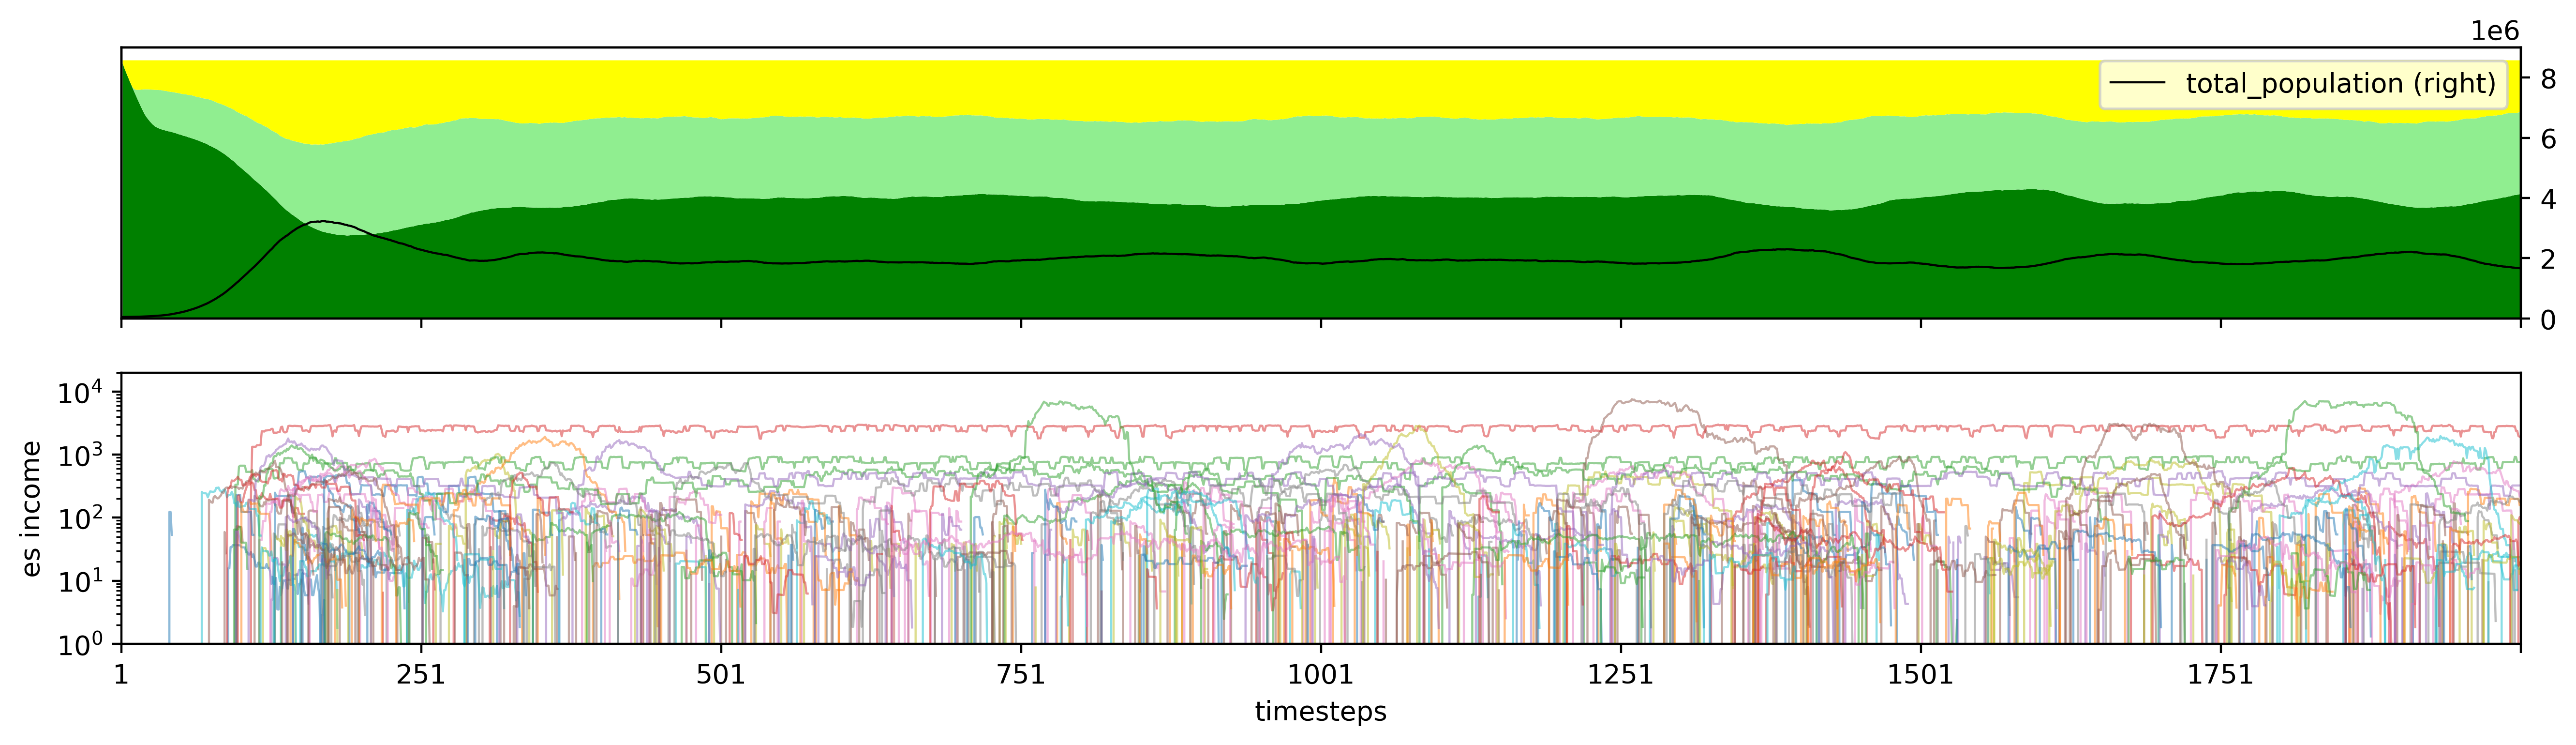

In [ ]:
aggregate_run_2 = pd.read_pickle(output_path + '/X2_local_dynamics/raw_data/1000000-1000000-1000000_s0.pkl')['aggregates']

# plot aggregate trajectory
fig, axes = plt.subplots(nrows=2, figsize=(16, 4), sharex=True, dpi=400)

# forest state
axes[0].stackplot(
    aggregate_run_2['time'],
    aggregate_run_2['forest_state_3_cells'], aggregate_run_2['forest_state_2_cells'], aggregate_run_2['forest_state_1_cells'],
    colors=['green', 'lightgreen', 'yellow']
)

# population
aggregate_run_2.plot('time', y='total_population', lw=.8, color='k', ax=axes[0], secondary_y=True, ylim=(0,9e6))

# draw random sample
es_2.iloc[:,sample_es].plot(ax=axes[1], lw=.8, alpha=.5, legend=False)
axes[1].set_yscale('log')
#axes[1].set_ylim(360, 1e5)
axes[1].set_xlim(0, 2000)
axes[1].set_ylim(1, 2e4)
axes[1].set_ylabel('es income')
axes[1].set_xlabel('timesteps')

In [13]:
# select settlements that reach populations greater than 20 000, thereby reach the maximum possible radius of influence
large_indices = (pop_2.max() > 2e4)
pop_large = pop_2.loc[:, large_indices]
es_large = es_2.loc[:, large_indices]

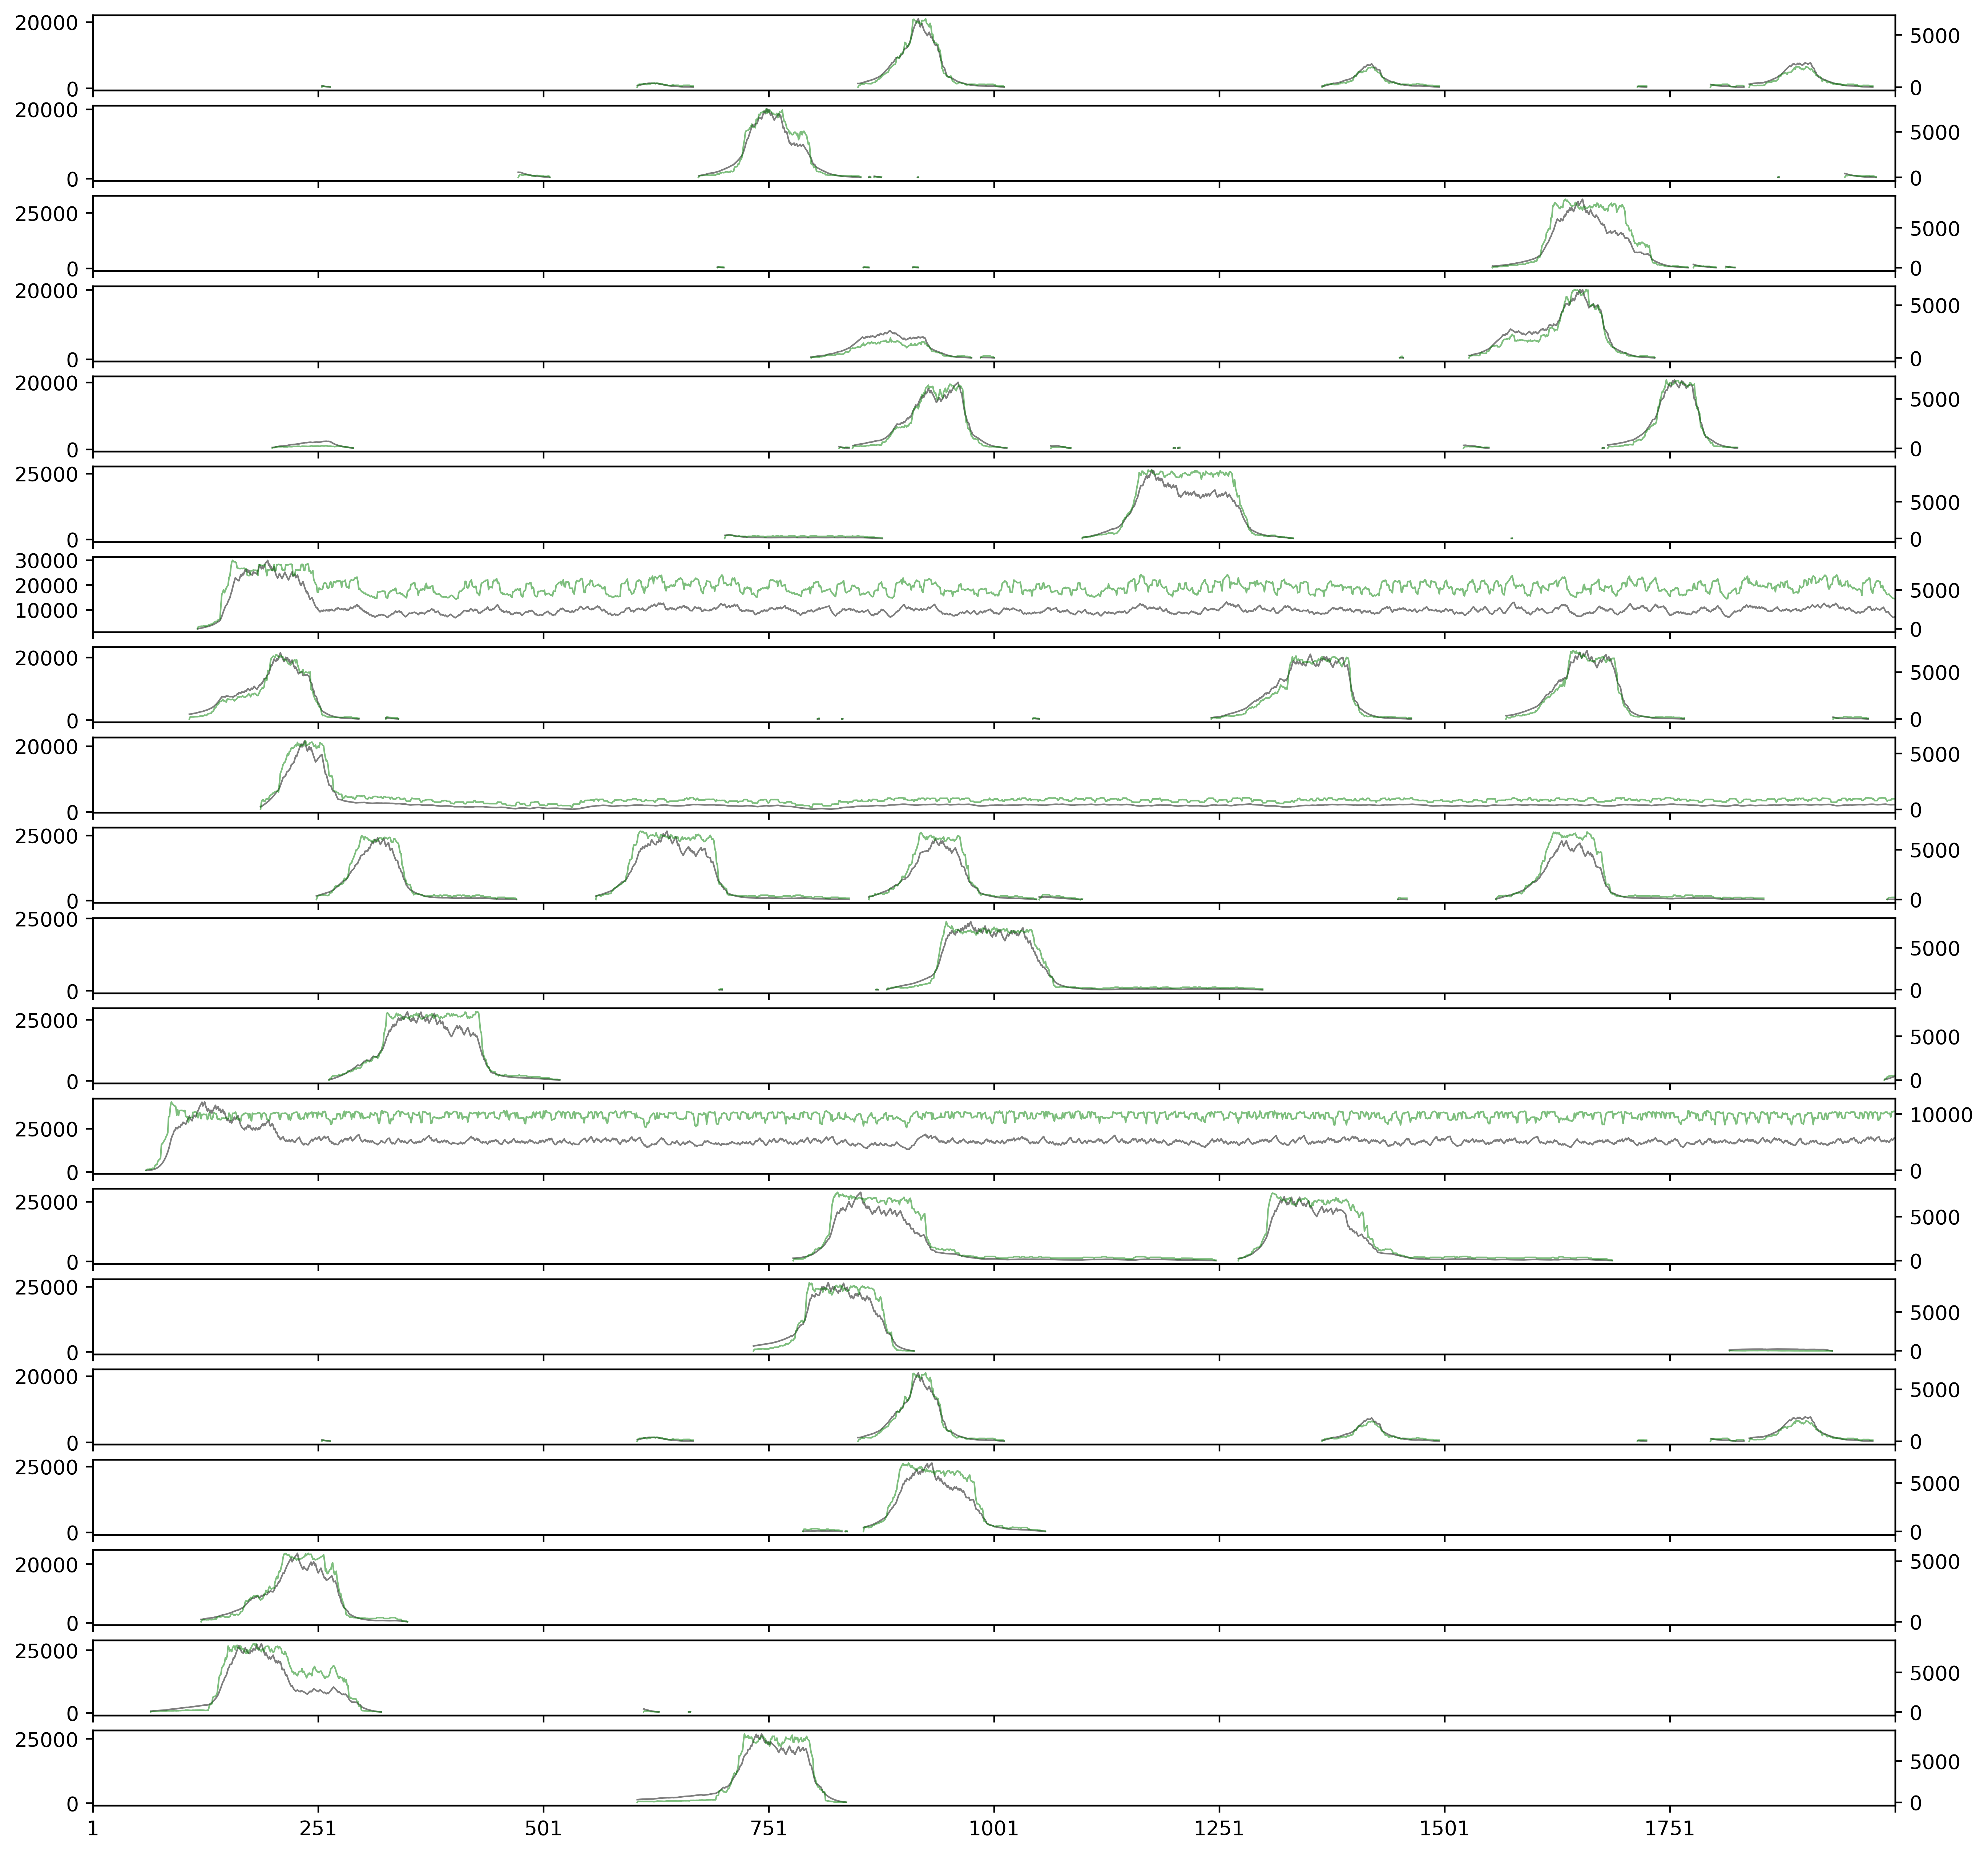

In [14]:
# draw random sample
n_sample = 20
sample = np.random.randint(0, pop_large.shape[1], size=n_sample)

fig, axes = plt.subplots(nrows=n_sample, figsize=(16, 16), sharex=True, dpi=400)

for n, s in enumerate(sample):
    pop_large.iloc[:,s].plot(ax=axes[n], c='k', lw=.8, alpha=.5, legend=False, xlim=(0,2000))
    es_large.iloc[:,s].plot(ax=axes[n], c='g', lw=.8, alpha=.5, secondary_y=True, legend=False, xlim=(0,2000))

ok, this looks like everything is fine. maybe there's just something wrong with the movie function then.